## Example 2: Performing a spectral fit using artificial data in the UV/Vis
Part of ESE 156 Remote Sensing Class; Julia Version, 2019; Christian Frankenberg

---
The purpose of this exercise is to go one step further, understanding how we can phrase observed log(radiances) as a linear system of equations (in Matrix form), using absorption optical depths by a set of absorbers and a simple polynomial for surface properties (we can assume we are having an artificial light shining back and forth a chamber).

Most of the absorption cross sections used here are obtained via

http://www.iup.uni-bremen.de/gruppen/molspec/databases/index.html

http://spectrolab.aeronomie.be/o2.htm

In the UV/Vis, a lot of the cross sections are derived in the lab and not just theoretical predictions. This is kind of a different inverse problem where the concentration in the cell as well as the cell-length, pressure and temperature is known, allowing them to derive the absorption cross section $\sigma$.

In the most basic sense, we are making use of Beer's law here (https://en.wikipedia.org/wiki/Beer%E2%80%93Lambert_law):
$$I(\lambda) = I_0(\lambda)\cdot \exp\left(-\sum_{i=1}^N \sigma_i \int_0^l n_i(z)dz\right)\cdot Poly(\lambda)$$

The basic question here is how can we define a Matrix based linear forward model if we want to retrieve the column density ($\int_0^l n_i(z)dz$, in $molec/cm^2$) for each trace gas $i$, with respective cross section $\sigma_i$ (in $cm^2$)?

In [1]:
# using PyCall (enables python calls, not yet used here)
using Plots          # For Plots
using DelimitedFiles # For reading text files
# using LaTeXStrings (with this, you can use LaTex for labels)
using Interpolations # For interpolations
using Polynomials    # Polynomials
using Statistics     # mean, std, etc

----
Never a bad idea to learn some helpful scripting for automated data processing. This is still clumsy but you get the gist, files are being automatically downloaded. If I had more time, I would use a dictionary for all of this. So here, we basically download files from our FTP server, create a folder and save everything in there (if it doesn't yet exist).

In [2]:
# Get files (create sub directory and download files from server!)
try
    mkdir("files")
catch
    println("Dir exists")
end
for file in ["No2_293h.dat","No2_260h.dat","BrO_Cross_298K_Static_FTS_4cm.dat","so2_16.nm.dat","ozone_crossSection.dat","glyoxal_cross_section.dat"]
    saveFile   = "./files/"*file
    if !isfile(saveFile)
        download("ftp://fluo.gps.caltech.edu/XYZT_ESE156/Data/xSections/"*file, "./files/"*file)
    else
        println(saveFile, " already downloaded...")
    end
end

Dir exists
./files/No2_293h.dat already downloaded...
./files/No2_260h.dat already downloaded...
./files/BrO_Cross_298K_Static_FTS_4cm.dat already downloaded...
./files/so2_16.nm.dat already downloaded...
./files/ozone_crossSection.dat already downloaded...
./files/glyoxal_cross_section.dat already downloaded...


---
Now we have to read in all text files (note, different files have different structures (no of columns, etc). Within these files, we basically have a set of tabulated $\sigma_i(\lambda)$ for a couple of trace gases.

In [3]:
# Reading in cross sections:
no2_293 = readdlm("files/No2_293h.dat", comments=true, comment_char='#');
no2_260 = readdlm("files/No2_260h.dat", comments=true, comment_char='#');
bro = readdlm("files/BrO_Cross_298K_Static_FTS_4cm.dat", comments=true, comment_char='#');
so2 = readdlm("files/so2_16.nm.dat", comments=true, comment_char='#');
o3 = readdlm("files/ozone_crossSection.dat", comments=true, comment_char='#');
glyo = readdlm("files/glyoxal_cross_section.dat", comments=true, comment_char='#');

---
Let's just get an overview of all the cross sections (log-scale is easier, as the dynamic range is pretty large). Note the very strong ozone absorptions in the UV/Vis, you should know what effect they have near the Earth's surface.  

In [4]:
# Plotting (note, with the ! at the end, it is overplotting stuff over the previous plot)
plot(no2_293[:,1],no2_293[:,3], yaxis=:log, label="NO2")
#plot!(bro[:,1],bro[:,2], yaxis=:log)
plot!(o3[:,1],o3[:,2], yaxis=:log, label="O3")
plot!(so2[:,1],so2[:,2], yaxis=:log, label="SO2")
plot!(glyo[:,2],glyo[:,4], yaxis=:log, label="Glyoxal")
ylims!((1e-24,2e-17))
xlims!((260,600))
ylabel!("Cross Section (cm2/molec)")
xlabel!("Wavelength (nm)")

In [5]:
# Now I want to get all cross sections on a common wavelength grid. 
# So I first have to define a grid (collect just creates an array out of a range)
wl = collect(405:0.05:465);

---
Now interpolate cross sections to common grid

In [6]:
# Not the best solution here but the quickest way for me to 
# do interpolation on an unequal x-grid 
no2_cs1 = interpolate((no2_293[end:-1:1,1],), no2_293[end:-1:1,3],Gridded(Linear()))(wl);
no2_cs2 = interpolate((no2_260[end:-1:1,1],), no2_260[end:-1:1,3],Gridded(Linear()))(wl);
o3_cs   = interpolate((o3[:,1],), o3[:,2],Gridded(Linear()))(wl);
glyo_cs = interpolate((glyo[:,2],), glyo[:,4],Gridded(Linear()))(wl);

---
and plotting all interpolated ones again (multiplying by 1e20, the plots get weird axes otherwise ). Note that the NO2 cross sections depend a bit on temperature (we will go into all of these aspects later in more detail)

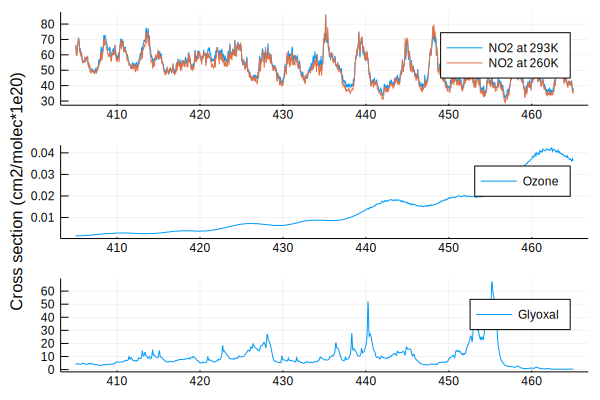

In [7]:
#plotly()
p1 = plot(wl,no2_cs1*1e20, label="NO2 at 293K")
plot!(wl,no2_cs2*1e20, label="NO2 at 260K")
p3 = plot(wl,o3_cs*1e20, label="Ozone")
ylabel!("Cross section (cm2/molec*1e20)")
p4 = plot(wl,glyo_cs*1e20, label="Glyoxal")

plot(p1,p3,p4,layout=(3,1))

### Create a pseudo-measurement (with random noise)
Let's create some pseudo measurement using 3 species only, Ozone, NO2 and Glyoxal, for which we assume a vertical column density of 1e19, 1.5e16 and 1e15 molec/cm$^2$, respectively (somewhat realistic numbers for the Earth's atmosphere)

This is all step-by-step, eventually, we want to write functions F(x) for this

In [18]:
#  First a polynomial term
p = Poly([2,-0.002,0.00003]) 

# Solar Zenith Angle 
# (I hope you know what this is, 0 degree is sun right above you, 90 at horizon)
sza = 40.0

# Vertical column densities (VCD) in molec/cm2
vcd_no2 = 1.5e16
vcd_o3  = 1e19
vcd_glyo = 1.0e15

# Create some fake measurement with specific vertical columns. Convert Vertical column into slant column:
AMF = 1.0+1.0/cos(deg2rad(sza))

# Lambert Beer law (just with a prefactor polynomial)
I = exp.(-AMF*vcd_o3*o3_cs).*exp.(-AMF*vcd_no2*no2_cs1).*exp.(-AMF*vcd_glyo*glyo_cs).*p(wl.-440)

# Give it roughly an signal-to-noise ratio (SNR) of 300 
SNR = 300

# This is crude, we will go through later in class how we can develop instrument noise models
ϵ = mean(I)/SNR;
n = length(I)
# Add noise to our measurements
I = I.+randn(n)ϵ;

In [19]:
p

Poly(2.0 - 0.002*x + 3.0e-5*x^2)

--- 
## Plot (and comparison to a TROPOMI ATBD example)
ATBD = Algorithm Theoretical Basis Document (typical satellite lingo)

Here is the ATBD version:
<img src="https://d3i71xaburhd42.cloudfront.net/821ab62d3a88f33db0c7c9ac2ea787592c1bcd01/22-Figure4-1.png" alt="Actual plot from TROPOMI ATBD" style="width:400px">

---
Let's plot our pseudo-measurement from space as well now (and see how well we can fit it):

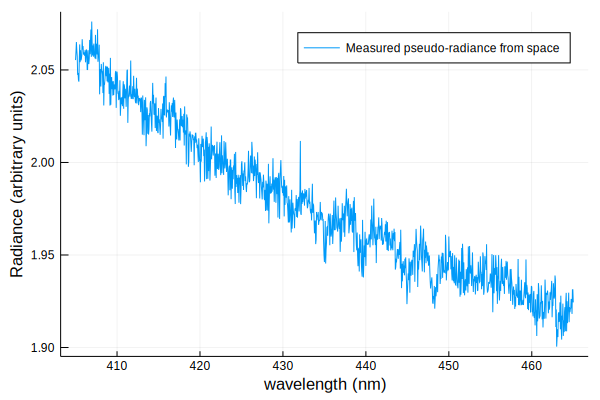

In [20]:
plot(wl,I, label="Measured pseudo-radiance from space")
xlabel!("wavelength (nm)")
ylabel!("Radiance (arbitrary units)")

--- 
### So, how do fit the vertical column densities of each gas? Can you set this up?
Let's first try to fit a simple polynomial and see what effect it has

In [21]:
# Let's try to fit a simple Poynomial
# Define K matrix here 
K = [ones(n) wl wl.^2]

# Solve Normal Equation:
x = inv(K'K)K'I

3-element Array{Float64,1}:
  7.376518086019489   
 -0.0225560281183236  
  2.328248839473663e-5

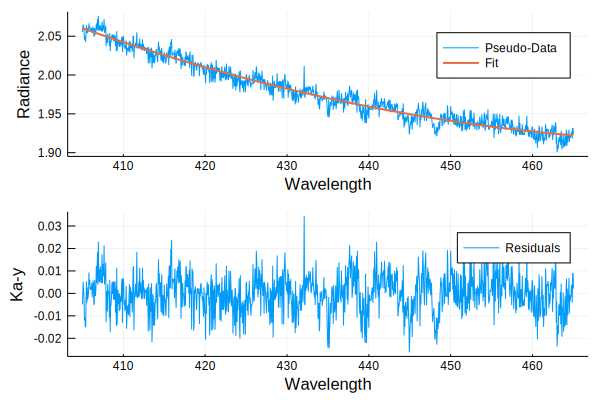

In [22]:
p1 = plot(wl, I, ylabel="Radiance", xlabel="Wavelength", label="Pseudo-Data" )
# Reconstruct fit:
plot!(wl, K*x, lw=2, label="Fit")

# Plot residuals
p2 = plot(wl, I-K*x, ylabel="Ka-y", xlabel="Wavelength", label="Residuals")
plot(p1, p2, layout = (2,1))

### Polynomial as short-pass filter
The polyomial basically acted as a short-pass filter, taking out all broadband variations in the spectrum, keeping the high-frequency absorptions intact (this enables us to decouple smooth surface features from atmospheric properties, which are more high-frequent and have unique "fingerprints" per gas

[2.0487862890310762e19, 3.4567174310900092e16, 4.1321834471942e14, 3.6982614437097743, -0.012635868755793653, 1.3193196819391023e-5]


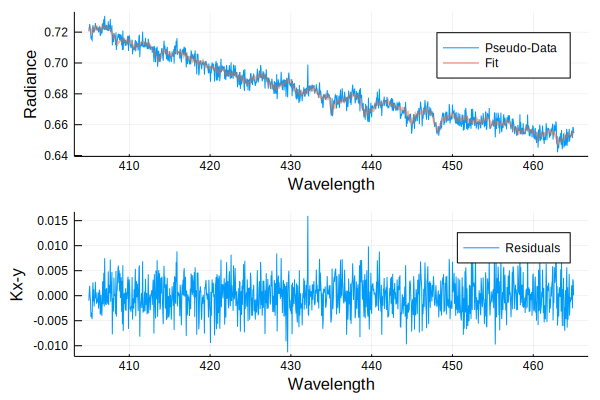

In [23]:
# Ok, let's try this again!
# How did we get to this here?:
K = [-o3_cs -no2_cs1 -glyo_cs  ones(n)  wl  wl.^2]

# Solve normal equations:
x = inv(K'K)K'log.(I)
println(x)

p1 = plot(wl, log.(I), ylabel="Radiance", xlabel="Wavelength", label="Pseudo-Data" )
# Reconstruct fit:
plot!(wl, K*x, lw=2, label="Fit", alpha=0.5)

# Plot residuals
p2 = plot(wl, log.(I)-K*x, ylabel="Kx-y", xlabel="Wavelength", label="Residuals")
plot(p1, p2, layout = (2,1))


____ 
Let's make a pretty plot of all the fit components now
## Voila, your first spectral fit!

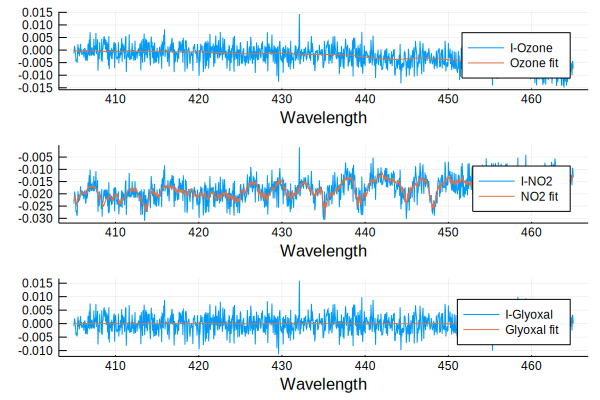

In [24]:
#leg = ["Ozone","NO2","Glyoxal"]
gas_fits = zeros((n,3))
res_gas_fits = zeros((n,3))
# Just use the Trace gases here, not the polynomial coefficients
for i = 1:3
    x_copy = copy(x)
    x_copy[i]=0
    res_gas_fits[:,i]=log.(I)-K*x_copy
    gas_fits[:,i]=K*(x.-x_copy)
end
plot(wl, res_gas_fits, layout = (3,1), label=["I-Ozone" "I-NO2" "I-Glyoxal"])
plot!(wl, gas_fits, layout = (3,1), label=["Ozone fit" "NO2 fit" "Glyoxal fit"])
xlabel!("Wavelength")

### Things we ignored here for now:

<li> A true solar spectrum with absorptions (we kind of used a spectrally flat sun)
<li> Ring effect that causes a pseudo-absorber due to rotational Raman scattering, e.g. https://pdfs.semanticscholar.org/5b93/dd80de9d017ddb9a48a3380e576d31638210.pdf
<li> An instrument function (apart from a sampling we used)
<li> Changes in spectral characteristics (shift and squeeze of the wavelength grid)

______________________
<font color=red>**Homework:** (in class now to get your feet wet)</font> 

Rewrite the system as weighted least squares and compute the errors for each trace gas as a function of SNR (say from 50-5000)? 

What SNR is needed to determine NO2 with a precision (1-$\sigma$) of 5%?

Try different orders for the polynomials. What happens if you use a 1st order or 3rd order? Any idea what type of functions might be better than polynomials?


Add the NO$_2$ cross section for both temperatures in the linear system? 
- What happens if you fit both at the same time (you can use an ensemble of fits using different noise realizations)? 
- Can you explain this behavior with the posterior covariance matrix? 
- What might be the reason for this behavior (mathematically speaking) and how could you stabilize the fit?

### Another complication for stronger absorbers:
So far, we have basically assumed that the Airmass factor AMF is independent of wavelength, allowing us to separate the retrievals of Slant Column Densities from the actual radiative transfer calculations that would allow us to infer Vertical columns from Slant columns (in the easiest case, just from geometric considerations as explained above).

Once strong absorptions take place (or scattering cross sections change rapidly), the AMF can depend on wavelength. Ozone in the UV is a prominent example as its cross section varies by 1-2 orders of magnitude within just 30-40nm. In the more strongly absorbing wavelenths, most of the measured photons will come from atmospheric scattering while the average penetration depth increases with decreasing cross section. Also, in the UV Rayleigh scattering is very strong and surface scattering contribution less so than in the Vis and near-infrared. 

For these kind of retrievals, some of our assumptions break down and we would need to really couple radiative transfer calculations to the retrieval (which might enable us to also retrieve some vertical profile information, more on that later).

### Ozone (impact on UV radiation):
Typical Ozone columns are around 300Dobosn units (1DU = 2.69e16)
The figure below shows the vertical transmission of a typical atmosphere and indicates the 2 spectral position of the Dobson spectrophotometer (just as line, should have a finite width)


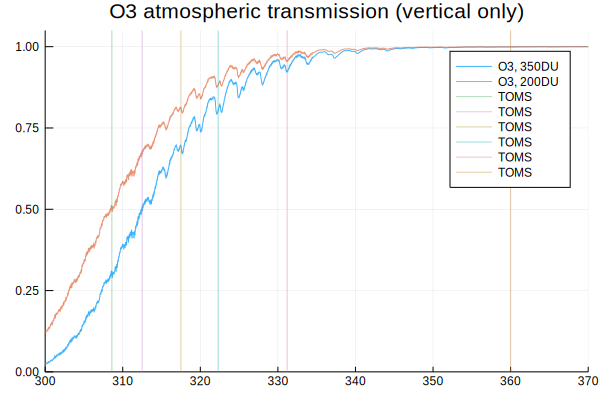

In [14]:
toms = [308.6 312.5 317.5 322.3 331.2 360.0]
plot(o3[:,1], exp.(-350*2.69e16*o3[:,2]),label="O3, 350DU", alpha=0.75)
plot!(o3[:,1], exp.(-200*2.69e16*o3[:,2]),label="O3, 200DU", alpha=0.75)
for i =1:length(toms)
    plot!([toms[i],toms[i]],[0,1.05], alpha=0.4, label="TOMS")
end
ylims!((0.0,1.05))
xlims!((300,370))
title!("O3 atmospheric transmission (vertical only)")